# Geochronology

This Jupyter notebook (Python 3 kernel) plots the $^{206}$Pb/$^{238}$U date and 2$\sigma$ uncertainties of individual zircons.

## Standard Modules

Import standard modules included in most Python 3 distributions:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

## Functions

This function generates the date distribution plots:

In [2]:
def plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colours, labels,
               legend=True, figsize=None, ylim=None, lineweight=None, bbox_to_anchor=None, mean_box=None):
    """
    Make a date distribution plot.
    
    Parameters
    ----------
    zircon_means : list of numpy arrays
        individual zircon mean dates (each array being a sample, and each element of that array being a zircon)
    
    zircon_2sigmas : list of numpy arrays
        individual zircon 2 sigmas (each array being a sample, and each element of that array being a zircon)
        
    include : list of lists
        'yes' or 'no' for inclusion of individual zircon in mean (each array being a sample, and each element of
        that array being a zircon)
        
    sample_means : list
        sample mean dates (each element being a sample)
        
    sample_2sigmas : list
        sample 2 sigmas (each element being a sample)
        
    colours : list
        sample colours for plotting (each element being a sample)
        
    labels : list
        sample labels for the legend (each element being a sample)
        
    legend : boolean
        if True, plot legend (default True, optional)
        
    figsize : tuple
        figure size (default None, optional)
        
    ylim : tuple
        figure y limits (default None, optional)
        
    lineweight : float
        line weight for individual zircons (default None, optional)
        
    bbox_to_anchor : tuple
        for manual placement of the legend (default None, optional)
        
    mean_box : list
        booleans, for decided whether to draw the mean and 2 sigma for a sample (default None, optional)
        
    Returns
    -------
    fig : figure handle
    
    ax : axis handle
    """
    # formatting constants
    zircon_spacing = 1
    sample_spacing = 6 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    # iterate over each sample
    plot_mean_box = False
    for i in range(n_samples):
        
        # number of zircons in sample
        n_zircons = len(zircon_means[i])
        
        # check if we need to plot the mean box
        if mean_box==None:
            plot_mean_box = True
        elif mean_box[i]:
            plot_mean_box = True
        
        # iterate over each zircon to find the mean box coordinates
        if plot_mean_box:
            
            # start coordinates
            for j in range(n_zircons):
                if include[i][j] == 'yes':
                    start_box_x = current_x + j*zircon_spacing - zircon_spacing/2
                    break
            
            # end coordinates
            for j in -(np.arange(n_zircons,dtype=int)+1):
                if include[i].iloc[j] == 'yes':
                    end_box_x = current_x + (n_zircons+j)*zircon_spacing + zircon_spacing/2
                    break

            # plot the mean box
            # the 2sigma uncertainty on the sample age
            if sample_2sigmas != None:
                rectangle = matplotlib.patches.Rectangle((start_box_x, sample_means[i]-sample_2sigmas[i]),
                                                         (end_box_x-start_box_x), sample_2sigmas[i]*2,
                                                         facecolor='C7',edgecolor='none')
                ax.add_patch(rectangle)

            # the mean age
            if sample_means != None:
                ax.hlines(sample_means[i], start_box_x, end_box_x, colors='k')
        
        # iterate over each zircon to plot the zircons
        marked = False # legend control
        for j in range(n_zircons):
            
            if marked:
                if include[i][j] == 'yes':
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=yes_alpha)
                else:
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
            else:
                if include[i][j] == 'yes':
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                    marked = True
                else:
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
                
            # tick the x to the next zircon
            current_x = current_x + zircon_spacing
        
        # tick the x to the next sample
        current_x = current_x + sample_spacing
        
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('$^{206}$Pb/$^{238}$U date [Ma]')
    if legend:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax

In [3]:
def weighted_mean(dates,sigma):
    
    """
    calculated a weighted mean from dates and uncertainities
    
    input parameters
    ----------------
    dates: date of individual grains
    sigma: 1 sigma uncertainty associated with dates
    
    returns
    ----------------
    weighted_mean, 2 sigma uncertainty
    
    """
    
    inverse_variance=[]
    alpha=[]
    weighted_mean_calc=[]
    
    for n in range(0,len(dates)):
        value = 1/sigma[n]**2
        inverse_variance.append(value)
    inverse_variance_sum = np.sum(inverse_variance)
    
    for n in range(0,len(dates)):
        value = (1/sigma[n]**2)/inverse_variance_sum
        alpha.append(value)
        
    #calculate the weights for each date
    for n in range(0,len(dates)):
        value = alpha[n]*dates[n]
        weighted_mean_calc.append(value)
    
    #take the sum of the weights multiplied by the dates to get the weighted
    #mean (equation 64 of McLean et al., 2011)
    weighted_mean = np.sum(weighted_mean_calc)
    
    #the variance of the weighted mean is simply the inverse of the sum of
    #the inverse variances of each date (equation 66 of McLean et al., 2011)
    variance = 1/inverse_variance_sum
    
    weighted_mean_sigma = np.sqrt(variance)
    
    n = len(dates)
    
    print('The weighted mean is:')

    print(weighted_mean)

    print('With a 2sigma error of:')

    print(2*weighted_mean_sigma)
    
    print('N=' )
    print(n)
    
    return weighted_mean, 2*weighted_mean_sigma

## Dates

Import the data:

In [4]:
this_study = pd.read_csv('../Data/this_study.csv')
this_study['sample'].unique()

array(['17080201', 'HZ-8-2', 'HZ-59-6', 'HZ-470', 'LM1.84', 'LM27.19',
       'QR8-74-0', 'FDM14-1'], dtype=object)

In [5]:
# separate samples
Madiyi = this_study[this_study['sample']=='17080201'].copy()
Liantuo = this_study[this_study['sample']=='FDM14-1'].copy()
H3_8 = this_study[this_study['sample']=='HZ-8-2'].copy()
H3_60 = this_study[this_study['sample']=='HZ-59-6'].copy()
H2_470 = this_study[this_study['sample']=='HZ-470'].copy()
L4_2 = this_study[this_study['sample']=='LM1.84'].copy()
L1_27 = this_study[this_study['sample']=='LM27.19'].copy()
QR_74 = this_study[this_study['sample']=='QR8-74-0'].copy()

# sort
Madiyi.sort_values(by='206Pb/238U', ascending=True, inplace=True)
Liantuo.sort_values(by='206Pb/238U', ascending=True, inplace=True)
H3_8.sort_values(by='206Pb/238U', ascending=True, inplace=True)
H3_60.sort_values(by='206Pb/238U', ascending=True, inplace=True)
H2_470.sort_values(by='206Pb/238U', ascending=True, inplace=True)
L4_2.sort_values(by='206Pb/238U', ascending=True, inplace=True)
L1_27.sort_values(by='206Pb/238U', ascending=True, inplace=True)
QR_74.sort_values(by='206Pb/238U', ascending=True, inplace=True)

# reset index
Madiyi.reset_index(inplace=True, drop=True)
Liantuo.reset_index(inplace=True, drop=True)
H3_8.reset_index(inplace=True, drop=True)
H3_60.reset_index(inplace=True, drop=True)
H2_470.reset_index(inplace=True, drop=True)
L4_2.reset_index(inplace=True, drop=True)
L1_27.reset_index(inplace=True, drop=True)
QR_74.reset_index(inplace=True, drop=True)

In [6]:
Xian2020 = pd.read_csv('../Data/Xian2020a.csv')
Xian2020.sort_values(by='206Pb/238U', ascending=True, inplace=True)
Xian2020.reset_index(inplace=True, drop=True)

In [7]:
Lan2015 = pd.read_csv('../Data/Lan2015a.csv')
Lan2015.sort_values(by='206Pb/238U', ascending=True, inplace=True)
Lan2015.reset_index(inplace=True, drop=True)

Pull out/define the necessary variables:

In [8]:
zircon_means = [H2_470['206Pb/238U'],
                L1_27['206Pb/238U'],
                L4_2['206Pb/238U'],
                QR_74['206Pb/238U'],
                H3_60['206Pb/238U'],
                H3_8['206Pb/238U'],
                Madiyi['206Pb/238U'],
                Xian2020['206Pb/238U'],
                Liantuo['206Pb/238U'],
                Lan2015['206Pb/238U']]

zircon_2sigmas = [H2_470['206Pb/238U_2sigma'],
                  L1_27['206Pb/238U_2sigma'],
                  L4_2['206Pb/238U_2sigma'],
                  QR_74['206Pb/238U_2sigma'],
                  H3_60['206Pb/238U_2sigma'],
                  H3_8['206Pb/238U_2sigma'],
                  Madiyi['206Pb/238U_2sigma'],
                  Xian2020['206Pb/238U_sigma']*2,
                  Liantuo['206Pb/238U_2sigma'],
                  Lan2015['206Pb/238U_sigma']*2]

include = [H2_470['include'],
           L1_27['include'],
           L4_2['include'],
           QR_74['include'],
           H3_60['include'],
           H3_8['include'],
           Madiyi['include'],
           Xian2020['include'],
           Liantuo['include'],
           Lan2015['include']]

sample_means = [815.73,
                814.19,
                813.06,
                811.47,
                809.52,
                804.56,
                804.90,
                801.90,
                779.52,
                732]

sample_2sigmas = [0.18,
                  0.21,
                  0.35,
                  0.67,
                  0.50,
                  0.39,
                  0.36,
                  6.3,
                  0.26,
                  10]

labels = ['H2-470',
          'L1-27',
          'L4-2',
          'QR-74',
          'H3-60',
          'H3-8',
          'Madiyi Fm. - this study',
          'Madiyi Fm. - Xian et al. (2020)',
          'Liantuo Fm. - this study',
          'Liantuo Fm. - Lan et al. (2015)']

## Plots

### Everything

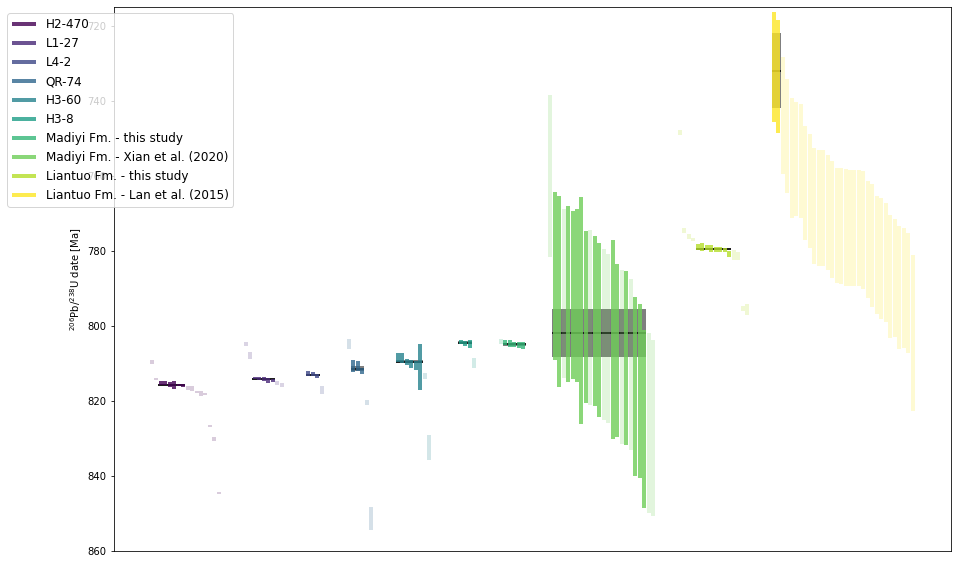

In [9]:
colors = plt.cm.viridis(np.linspace(0,1,len(sample_means)))

fig, ax = plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colors, labels,
                     figsize=(15,10), lineweight=4, bbox_to_anchor=(0.15,1), ylim=(860,715))
ax.set_xticks([])
plt.show(fig)

### Banxi

In [10]:
zircon_means = [H2_470['206Pb/238U'],
                L1_27['206Pb/238U'],
                L4_2['206Pb/238U'],
                QR_74['206Pb/238U'],
                H3_60['206Pb/238U'],
                H3_8['206Pb/238U']]

zircon_2sigmas = [H2_470['206Pb/238U_2sigma'],
                  L1_27['206Pb/238U_2sigma'],
                  L4_2['206Pb/238U_2sigma'],
                  QR_74['206Pb/238U_2sigma'],
                  H3_60['206Pb/238U_2sigma'],
                  H3_8['206Pb/238U_2sigma']]

include = [H2_470['include'],
           L1_27['include'],
           L4_2['include'],
           QR_74['include'],
           H3_60['include'],
           H3_8['include']]

sample_means = [815.73,
                814.19,
                813.06,
                811.47,
                809.52,
                804.56]

sample_2sigmas = [0.18,
                  0.21,
                  0.35,
                  0.67,
                  0.50,
                  0.39]

labels = ['H2-470',
          'L1-27',
          'L4-2',
          'QR-74',
          'H3-60',
          'H3-8']

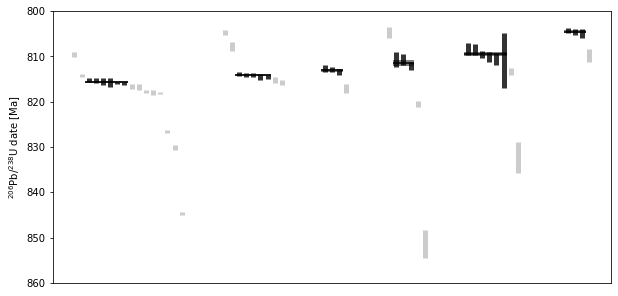

In [11]:
colors = ['k']*len(labels)

fig, ax = plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colors, labels,
                     figsize=(10,5), lineweight=5, ylim=(860,800), legend=False)
ax.set_xlim(0,78) #to maintain consistent axis sizes between figures
ax.set_xticks([])
#plt.savefig('../Output/Banxi_zircons.pdf',bbox_inches='tight')
plt.show(fig)

### Madiyi

In [12]:
zircon_means = [Madiyi['206Pb/238U'],
                Xian2020['206Pb/238U']]

zircon_2sigmas = [Madiyi['206Pb/238U_2sigma'],
                  Xian2020['206Pb/238U_sigma']*2]

include = [Madiyi['include'],
           Xian2020['include']]

sample_means = [804.90,
                801.90]

sample_2sigmas = [0.36,
                  6.3]

labels = ['Madiyi Fm. - this study',
          'Madiyi Fm. - Xian et al. (2020)']

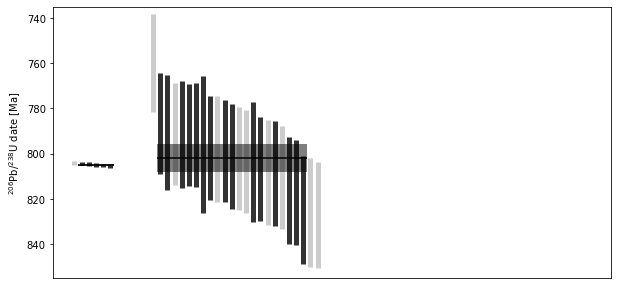

In [13]:
colors = ['k']*len(labels)

fig, ax = plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colors, labels,
                     figsize=(10,5), lineweight=5, ylim=(855,735), legend=False)
ax.set_xlim(0,78) #to maintain consistent axis sizes between figures
ax.set_xticks([])
#plt.savefig('../Output/Madiyi_zircons.pdf',bbox_inches='tight')
plt.show(fig)

### Liantuo

Youngest 2 grains, as in Lan et al. (2015):

In [14]:
Lan2015_mean, Lan2015_2sigma = weighted_mean(Lan2015['206Pb/238U'][0:2], Lan2015['206Pb/238U_sigma'][0:2])

The weighted mean is:
732.1648712798977
With a 2sigma error of:
10.462314017775247
N=
2


All the grains:

In [15]:
Lan2015_all_mean, Lan2015_all_2sigma = weighted_mean(Lan2015['206Pb/238U'], Lan2015['206Pb/238U_sigma'])

The weighted mean is:
769.6560526503374
With a 2sigma error of:
2.773869238871002
N=
32


In [16]:
zircon_means = [Liantuo['206Pb/238U'],
                Lan2015['206Pb/238U']]

zircon_2sigmas = [Liantuo['206Pb/238U_2sigma'],
                  Lan2015['206Pb/238U_sigma']*2]

include = [Liantuo['include'],
           Lan2015['include']]

sample_means = [779.52,
                Lan2015_mean]

sample_2sigmas = [0.26,
                  Lan2015_2sigma]

labels = ['Liantuo Fm. - this study',
          'Liantuo Fm. - Lan et al. (2015)']

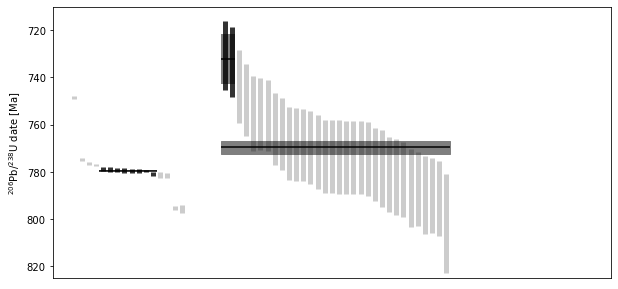

In [17]:
colors = ['k']*len(labels)

fig, ax = plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colors, labels,
                     figsize=(10,5), lineweight=5, ylim=(825,710), legend=False)
ax.set_xlim(0,78) #to maintain consistent axis sizes between figures
ax.set_xticks([])

# weighted mean based on all zircons
rectangle = matplotlib.patches.Rectangle((23.5, Lan2015_all_mean-Lan2015_all_2sigma),
                                         len(Lan2015), Lan2015_all_2sigma*2, color='C7', zorder=-99)
ax.add_patch(rectangle)

ax.hlines(Lan2015_all_mean, 23.5, 23.5+len(Lan2015), colors='k')

#plt.savefig('../Output/Liantuo_zircons.pdf',bbox_inches='tight')
plt.show(fig)